# Intro Task, Object Localization

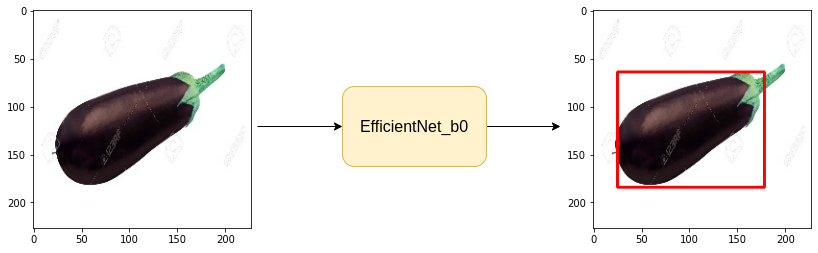

In [1]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-j02eqeb3
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-j02eqeb3
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [2]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 7.29 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [5]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'
DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140
LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'
NUM_COR = 4


In [6]:
# read the csv file
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

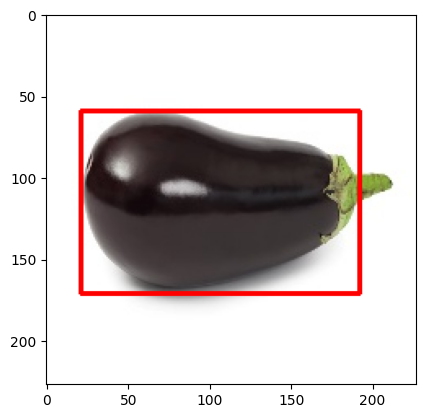

In [7]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [8]:
# split datasets into validation and train datasets
train_df, valid_df = train_test_split(df, test_size= 0.20, random_state= 42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
train_augs = A.Compose([
           A.Resize(IMG_SIZE, IMG_SIZE),
           A.HorizontalFlip(p=0.5),
           A.VerticalFlip(p =0.5),
           A.Rotate()
], bbox_params=A.BboxParams(format= 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
           A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format= 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [11]:
class ObjectLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox =[[xmin, ymin, xmax, ymax]]
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes= bbox, class_labels=[None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) /255.0 #(h, w, c) -> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox


In [12]:
trainset = ObjectLocDataset(train_df, train_augs)
validset = ObjectLocDataset(valid_df, valid_augs)

In [13]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


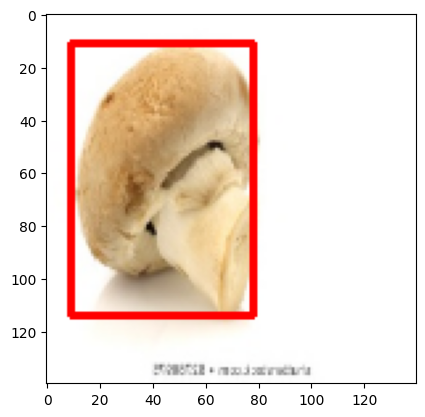

In [14]:
img, bbox = trainset[100]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)


In [16]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [17]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [18]:
from torch import nn
import timm

In [19]:
class ObjLocMod(nn.Module):
  def __init__(self):
    super(ObjLocMod, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes =4)

  def forward(self, images, gt_bboxes = None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss
    return bboxes

In [23]:
model = ObjLocMod()
model.to(DEVICE);

In [24]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [25]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() #Dropout ON

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    bboxes, loss = model(images, gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #update the model's parameters
    total_loss += loss.item()
  return total_loss/len(dataloader)


In [29]:
def valid_fn(model, dataloader):
  total_loss = 0.0
  model.eval() #Dropout OFF
  with torch. no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()
    return total_loss/len(dataloader)


#Training Loop

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [31]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = valid_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('WEIGHTS-ARE-SAVED')
    best_valid_loss = valid_loss

  print(f"EPOCH {i+1} ... train loss : {train_loss} ... valid loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 1 ... train loss : 1631.2453369140626 ... valid loss : 2018.7552083333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 2 ... train loss : 801.5097412109375 ... valid loss : 616.0937093098959


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 3 ... train loss : 572.2407592773437 ... valid loss : 181.07781982421875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 4 ... train loss : 415.22483825683594 ... valid loss : 145.9184544881185


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 5 ... train loss : 253.45891571044922 ... valid loss : 127.02180989583333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 6 ... train loss : 230.8186294555664 ... valid loss : 119.60939025878906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 7 ... train loss : 174.50588455200196 ... valid loss : 168.52910868326822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 8 ... train loss : 142.70172042846679 ... valid loss : 190.14765421549478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 9 ... train loss : 128.51122970581054 ... valid loss : 150.1800791422526


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 10 ... train loss : 108.69032821655273 ... valid loss : 97.75455729166667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 11 ... train loss : 105.65026931762695 ... valid loss : 97.90354665120442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 12 ... train loss : 93.38038902282715 ... valid loss : 110.90821329752605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 13 ... train loss : 89.6930435180664 ... valid loss : 82.82556660970052


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 14 ... train loss : 98.85486755371093 ... valid loss : 77.47517522176106


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 15 ... train loss : 81.64672164916992 ... valid loss : 73.61176045735677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 16 ... train loss : 63.54128074645996 ... valid loss : 89.91008758544922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 17 ... train loss : 57.754098892211914 ... valid loss : 84.03659057617188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 18 ... train loss : 47.46804542541504 ... valid loss : 83.09851837158203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 19 ... train loss : 59.467932319641115 ... valid loss : 72.55438995361328


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 20 ... train loss : 68.68590087890625 ... valid loss : 85.08346557617188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 21 ... train loss : 44.17670154571533 ... valid loss : 85.20006306966145


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
EPOCH 22 ... train loss : 42.905002212524415 ... valid loss : 53.317142486572266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 23 ... train loss : 54.36239395141602 ... valid loss : 89.66221110026042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 24 ... train loss : 40.30468254089355 ... valid loss : 65.28920491536458


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 25 ... train loss : 46.030892562866214 ... valid loss : 82.43256505330403


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 26 ... train loss : 43.772487831115725 ... valid loss : 100.67733510335286


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 27 ... train loss : 44.404713821411136 ... valid loss : 90.57745869954427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 28 ... train loss : 52.439675903320314 ... valid loss : 63.48805363972982


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 29 ... train loss : 42.924576377868654 ... valid loss : 57.69071960449219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 30 ... train loss : 36.541029930114746 ... valid loss : 82.00086720784505


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 31 ... train loss : 45.148458099365236 ... valid loss : 75.09809494018555


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 32 ... train loss : 45.58339252471924 ... valid loss : 83.29878234863281


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 33 ... train loss : 42.86476821899414 ... valid loss : 97.64384460449219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 34 ... train loss : 47.542931747436526 ... valid loss : 81.8116683959961


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 35 ... train loss : 44.02649688720703 ... valid loss : 70.53141657511394


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 36 ... train loss : 47.92514305114746 ... valid loss : 58.78858439127604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 37 ... train loss : 44.174635124206546 ... valid loss : 70.27487436930339


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 38 ... train loss : 33.97225837707519 ... valid loss : 71.95178858439128


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 39 ... train loss : 31.266578102111815 ... valid loss : 94.9087766011556


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 40 ... train loss : 48.35648441314697 ... valid loss : 56.81163533528646


#Inference

In [32]:
import utils

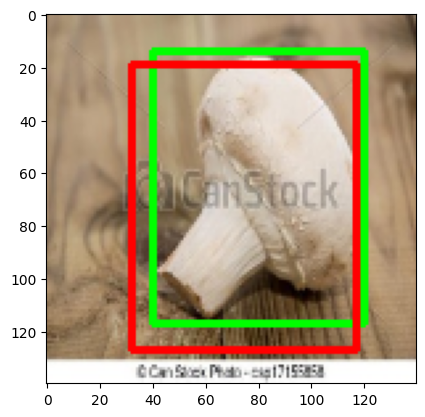

In [34]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
with torch.no_grad():
  image, gt_bbox = validset[23] #(c, h, w)
  image = image.unsqueeze(0).to(DEVICE) #(bs, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya